In [2]:
#!/usr/bin/python
import numpy as np
import numpy.linalg as la
import scipy.stats as st
import scipy.optimize as sopt
import matplotlib as mpl
import matplotlib.pyplot as plt
import os, math, sys
np.random.seed(88)
os.system('rm *.pdf *.eps *.png');

#### Problem definition

In [56]:
K = 2
Nphi = 2
acoeff  = np.ones((1,K))
mu  = np.zeros((Nphi,K))
Sig = np.zeros((Nphi,Nphi,K))
mu[0,0] = 1.0
mu[1,1] = 1.0
rho = -0.75
var = 0.02
fac = 0.5
Sig[:,:,0] = [[var,var*rho],[var*rho,var]]
Sig[:,:,1] = [[fac*var,fac*var*rho],[fac*var*rho,fac*var]]
r = 1e-03
s = 1e-03
print(acoeff.shape,mu.shape,Sig.shape)

(1, 2) (2, 2) (2, 2, 2)


In [57]:
Bmat = np.zeros((Nphi,Nphi,K))
Pmat = np.zeros((Nphi,Nphi,K))
mVec = np.zeros((Nphi,K))
Wraw = np.zeros((1,K))
Vmat = np.zeros((Nphi,K))
jVec = np.zeros((Nphi,1))
Hmat = np.zeros((Nphi,Nphi))
print(Wraw.shape)
print(mu[1,:])

(1, 2)
[0. 1.]


In [73]:
logalp = np.array([-2,-3])
alp = np.exp(logalp)
A = np.diag(alp)
Ain = np.diag(1/alp)
for i in range(0,K):
    Bmat[:,:,i] = Sig[:,:,i] + Ain
    Wraw[0,i] = acoeff[0,i]*st.multivariate_normal.pdf(mu[:,i],[0]*Nphi,Bmat[:,:,i])
    Pmat[:,:,i] = Ain - Ain@la.inv(Bmat[:,:,i])@Ain
    mVec[:,i] = Pmat[i,:,:]@la.inv(Sig[:,:,i])@mu[:,i]
    for j in range(0,Nphi):
        Vmat[j,i] = (1 - alp[j]*Pmat[j,j,i] + alp[j]*(mVec[j,i]**2))/(2.0*alp[j])
Lobj = np.log(np.sum(Wraw)) + np.sum(r*logalp-s*alp)
Wwght = Wraw/np.sum(Wraw)
for i in range(0,Nphi):
    jVec[i] = alp[i]*np.dot(Wwght,Vmat[i,:]) + r - s*alp[i]

In [3]:
def poststat(X,logalp):
    alp = np.exp(logalp)
    A = np.diag(alp)
    Pmat1 = la.inv(la.inv(cov1) + A)
    Pmat2 = la.inv(la.inv(cov2) + A)
    m1 = np.matmul(Pmat1,np.matmul(la.inv(cov1),mu1))
    m2 = np.matmul(Pmat2,np.matmul(la.inv(cov2),mu2))
    Bmat1 = la.inv(A) + cov1
    Bmat2 = la.inv(A) + cov2
    evid1 = st.multivariate_normal.pdf(mu1,[0,0],Bmat1) 
    evid2 = st.multivariate_normal.pdf(mu2,[0,0],Bmat2)
    evid = evid1+evid2
    w1 = evid1/evid
    w2 = evid2/evid
    postpdf = w1*st.multivariate_normal.pdf(X,m1,Pmat1) + w2*st.multivariate_normal.pdf(X,m2,Pmat2)
    priorpdf = st.multivariate_normal.pdf(X,[0,0],la.inv(A))
    likfun = st.multivariate_normal.pdf(X,mu1,cov1)+ st.multivariate_normal.pdf(X,mu2,cov2)
    v1 = [0.5*(1/alp[0] - Pmat1[0,0] + m1[0]**2),0.5*(1/alp[1] - Pmat1[1,1] + m1[1]**2)]
    v2 = [0.5*(1/alp[0] - Pmat2[0,0] + m2[0]**2),0.5*(1/alp[1] - Pmat2[1,1] + m2[1]**2)]
    jvec = [alp[0]*(w1*v1[0]+w2*v2[0]),alp[1]*(w1*v1[1]+w2*v2[1])]
    Hmat=np.zeros((2,2))
    Hmat[0,0] = alp[0]*alp[0]*(w1*(v1[0]*v1[0] + 0.5*Pmat1[0,0]**2) + w2*(v2[0]*v2[0] + 0.5*Pmat2[0,0]**2) - jvec[0]*jvec[0])
    Hmat[1,1] = alp[1]*alp[1]*(w1*(v1[1]*v1[1] + 0.5*Pmat1[1,1]**2) + w2*(v2[1]*v2[1] + 0.5*Pmat2[1,1]**2) - jvec[1]*jvec[1])
    Hmat[0,1] = alp[0]*alp[1]*(w1*(v1[0]*v1[1] + 0.5*Pmat1[0,1]**2) + w2*(v2[0]*v2[1] + 0.5*Pmat2[0,1]**2) - jvec[0]*jvec[1])
    Hmat[1,0] = Hmat[0,1]
    return likfun, priorpdf, postpdf, evid, jvec, Hmat

In [88]:
mpl.rcParams.update({'font.size':12})
Ngrd  = 100
evidplot   = np.zeros((Ngrd,Ngrd))
alp1bnd = [-5,10]
alp2bnd = [-5,10]
alp1g = np.linspace(alp1bnd[0],alp1bnd[1],Ngrd)
alp2g = np.linspace(alp2bnd[0],alp2bnd[1],Ngrd)
alp1grd,alp2grd = np.meshgrid(alp1g,alp2g)
for i in range(0,Ngrd):
    for j in range(0, Ngrd):
        alpCur = [alp1grd[i,j],alp2grd[i,j]]
        lk,prt,pst,evidplot[i,j],Jevd,Hevd = poststat([0,0],alpCur)

In [96]:
Niter = 15
logAlpIter = np.zeros((Niter,2))
def objFun(x):
    lk, pr, ps, ev, J, H = poststat([1,1],x) 
    return -np.log(ev)
def jacn(x):
    lk, pr, ps, ev, J, H = poststat([0,0],x) 
    return -np.array(J)
def hessn(x):
    lk, pr, ps, ev, J, H = poststat([0,0],x) 
    return -np.array(H)
X0 = np.array([-1,-3])
print(jacn(X0))
res = sopt.minimize(objFun, X0, method='Nelder-Mead',options={'maxiter':Niter,'return_all': True})
#res = sopt.minimize(objFun, X0, method='CG',jac = False, options={'maxiter':Niter,'return_all': True})
#res = sopt.minimize(objFun, X0, method='Newton-CG',jac = jacn, hess=hessn, options={'maxiter':Niter,'return_all': True})
print(res)
for i in range(0,res.nit):
    logAlpIter[i,:] = res.allvecs[i]
#print(logAlpIter)

[-0.58136393 -0.5130097 ]
       allvecs: [array([-1., -3.]), array([-1.075, -2.7  ]), array([-1.0125, -2.55  ]), array([-1.13125, -1.875  ]), array([-1.065625, -1.2375  ]), array([-1.2703125,  0.43125  ]), array([-1.24140625,  2.540625  ]), array([-1.63632812,  6.9328125 ]), array([-1.60742187,  9.0421875 ]), array([-1.60742187,  9.0421875 ]), array([-1.60742187,  9.0421875 ]), array([-1.60742187,  9.0421875 ]), array([-1.50927734, 12.05273438]), array([-1.29887695,  8.72519531]), array([-0.9973877 , 13.08251953])]
 final_simplex: (array([[-0.9973877 , 13.08251953],
       [-1.29887695,  8.72519531],
       [-1.50927734, 12.05273438]]), array([0.21901994, 0.329649  , 0.40113366]))
           fun: 0.21901994024997806
       message: 'Maximum number of iterations has been exceeded.'
          nfev: 30
           nit: 15
        status: 2
       success: False
             x: array([-0.9973877 , 13.08251953])


In [97]:
# Niter = 50
# alpIter = np.zeros((Niter,2))
# alpCur = [0,2]
# alpNew = [0,0]
# gamma = 0.1
# likfunc[i,j],priordist[i,j],postdist[i,j],evd,Jevd,Hevd = poststat(Xcur,np.exp(alpCur))
# print(Jevd,"\n",Hevd)
# for i in range(0,Niter):
#     alpIter[i,:] = alpCur
#     print(i,alpCur)
#     lk,pr,ps,evd,Jevd,Hevd = poststat(Xcur,np.exp(alpCur))
#     tmat = np.matmul(la.inv(Hevd),Jevd)
#     print("tmat:", tmat)
#     alpNew[0] = alpCur[0] + gamma*Jevd[0]
#     alpNew[1] = alpCur[1] + gamma*Jevd[1]
#     alpCur[0] = alpNew[0]
#     alpCur[1] = alpNew[1]

0.3868734488487349 0.5903295347732771
[0.2840542950453662, 0.7012462515517469] [0.12808399496454684, 0.9828871002215179]


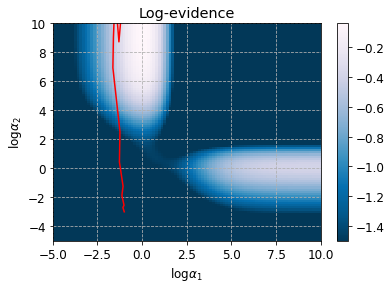

In [98]:
fig=plt.figure(2)
#plt.pcolor(alp1grd,alp2grd,np.log(evidplot),cmap='PuBu_r',vmin=-1)
plt.pcolor(alp1grd,alp2grd,np.log(evidplot),cmap='PuBu_r',vmin=-1.5)
plt.plot(logAlpIter[:,0],logAlpIter[:,1],'r-')
plt.colorbar()
plt.grid('on',linestyle='--')
plt.xlabel(r'$\log\alpha_1$')
plt.ylabel(r'$\log\alpha_2$')
plt.title('Log-evidence')
plt.xlim(alp1bnd)
plt.ylim(alp2bnd)
plt.savefig('evid2d_2.eps',bbox_inches='tight')
lk,prt,pst,ev1,Jev1,Hev1 = poststat([0,0],[ 3.64452806, -0.88226498])
lk,prt,pst,ev2,Jev2,Hev2 = poststat([0,0],[5,0])
print(ev1,ev2)
print(Jev1,Jev2)